In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cvxpy as cp
from numpy.linalg import norm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import LearningRateScheduler
from datetime import datetime

In [32]:
mean_rate_ur, mean_rate_em = 0.6, 5     #mean arrival rate of each uRLLC/embb user [packs/frame]
length = 10000                          #number of observations
T = 1000                                #number of frames
corr_factor = 0.95                      #correlation factor for time_series
rho = 0.99                              #correlation factor for channel
U_ur, U_em, U = 2, 1, 3                 #number of uRLLC/embb users and all users
M = 3                                   #number of RUs
k_0, K, h_0 = 8, 10**0.5, 1             #number of antenna in RU, Rician factor (db),Determinastic term of channel (LoS)
BW = 10e+03                             #Bandwidth of RUs (MHz)
P_max = 10**4.3                         #maximum RU transmit power (43dBm)
P_e = 10**-3                            #error probibilaty
N0 = 1e-11                              #Power of AWGN noise (W)
B_G = 180                               #Guard band (kHz)
beta1, beta2 = 360, 720                 #RB’s BW of numerology index 1,2 (kHz)
delta1, delta2 = 0.25, 0.125            #mini-slot’s duration of numerology index 1,2 (ms)
Delta = 0.5                             #each frame duration (ms)
R_th = 1e+03                            #minimum requirenment throughput for embb (1Mbps)
Z_ur, Z_em = 32*8, 125*8                #urllc packet size (32 B) and embb packet size (125KB)
D_ur = 0.5                             #delay requirenment of urllc (ms)
G0 = 10**(5/10)                         #minimum SNR
Q_max = 1e+09                           #Checking the buffer
R0, t0 = 5e+03, 1e-02                   #Refrence for data rate and latency
f1, f2 = 4, 2
t1, t2 = 2, 4

dim2, dim1 = M*U*f2*t2, M*U*f1*t1
em2_dims, em1_dims = M*U_em*f2*t2, M*U_em*f1*t1
ur2_dims, ur1_dims = M*U_ur*f2*t2, M*U_ur*f1*t1

nA2, nA1 = dim2, dim1
nS2 = nA2 + 2*U_ur + 1 + 2*M*U    #---->g^2,\lambda^ur,e^ur2,e^em2,q,V
nS1 = nA1 + 2*U_ur + 1 + 2*M*U    #---->g^1,\lambda^ur,e^ur1,e^em1,q,V

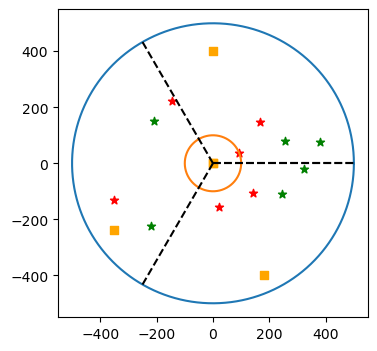

In [3]:
# Call topology 
%run topology.ipynb
dis_ur, dis_em = topology(6, 6)

In [4]:
predicted_lambda_ur = np.loadtxt("predicted_lambda_ur.csv", delimiter=',')
predicted_lambda_em = np.loadtxt("predicted_lambda_em.csv", delimiter=',')
actual_lambda_ur = np.loadtxt("actual_lambda_ur.csv", delimiter=',')
actual_lambda_em = np.loadtxt("actual_lambda_em.csv", delimiter=',')

In [14]:
predicted_lambda_em = predicted_lambda_em/3
actual_lambda_em = actual_lambda_em/3
predicted_lambda_ur = predicted_lambda_ur/2
actual_lambda_ur = actual_lambda_ur/2

In [19]:
predicted_lambda_ur = np.ones((T,U_ur))*3
predicted_lambda_em = np.ones((T,U_em))*10
actual_lambda_ur = np.ones((T,U_ur))*3
actual_lambda_em = np.ones((T,U_em))*10

In [38]:
class ReplayBuffer(object):
    
    def __init__(self, max_size, input_dims1, n_actions1, input_dims2, n_actions2):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory1 = np.zeros((self.mem_size,input_dims1))
        self.new_state_memory1 = np.zeros((self.mem_size,input_dims1))
        self.action_memory1 = np.zeros((self.mem_size,n_actions1)) 
        self.reward_memory1 = np.zeros(self.mem_size)
        self.state_memory2 = np.zeros((self.mem_size,input_dims2))
        self.new_state_memory2 = np.zeros((self.mem_size,input_dims2))
        self.action_memory2 = np.zeros((self.mem_size,n_actions2)) 
        self.reward_memory2 = np.zeros(self.mem_size)
        self.flag = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size) 
        
    def store_transition(self, state1, action1, reward1, state_1, state2, action2, reward2, state_2, flag, done): 
        index = self.mem_cntr % self.mem_size 
        self.state_memory1[index] = state1
        self.new_state_memory1[index] = state_1
        self.action_memory1[index] = action1
        self.reward_memory1[index] = reward1
        self.state_memory2[index] = state2
        self.new_state_memory2[index] = state_2
        self.action_memory2[index] = action2
        self.reward_memory2[index] = reward2
        self.flag[index] = flag
        self.terminal_memory[index] = 1 - int(done) 
        self.mem_cntr += 1
        
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace = False)
        states1 = self.state_memory1[batch]
        new_states1 = self.new_state_memory1[batch]
        actions1 = self.action_memory1[batch]
        rewards1 = self.reward_memory1[batch]
        states2 = self.state_memory2[batch]
        new_states2 = self.new_state_memory2[batch]
        actions2 = self.action_memory2[batch]
        rewards2 = self.reward_memory2[batch]
        flags = self.flag[batch]
        terminal = self.terminal_memory[batch]
        
        return states1, actions1, rewards1, new_states1, states2, actions2, rewards2, new_states2, flags, terminal

def binary_softmax2(x):
    b_size = tf.shape(x)[0]
    #tf.shape(x)[1]==>nA
    x2 = x[:,0:dim2]
    y2 = tf.zeros_like(x2)      
    for i in range(0, dim2, M*U):
        pair = x2[:, i:i+M*U]
        e_pair = tf.exp(pair - tf.reduce_max(pair, axis=1, keepdims=True))
        softmax_pair = e_pair / tf.reduce_sum(e_pair, axis=1, keepdims=True)
        for j in range(M*U):
            indices = tf.stack([tf.range(b_size), tf.fill([b_size], i+j)], axis=1)
            y2 = tf.tensor_scatter_nd_update(y2, indices, softmax_pair[:, j])    
    y = tf.reshape(y2, (b_size,dim2)) 
    return y
def binary_softmax1(x):
    b_size = tf.shape(x)[0]
    #tf.shape(x)[1]==>nA
    x1 = x[:,0:dim1]
    y1 = tf.zeros_like(x1)      
    for i in range(0, dim1, M*U):
        pair = x1[:, i:i+M*U]
        e_pair = tf.exp(pair - tf.reduce_max(pair, axis=1, keepdims=True))
        softmax_pair = e_pair / tf.reduce_sum(e_pair, axis=1, keepdims=True)
        for j in range(M*U):
            indices = tf.stack([tf.range(b_size), tf.fill([b_size], i+j)], axis=1)
            y1 = tf.tensor_scatter_nd_update(y1, indices, softmax_pair[:, j])    
    y = tf.reshape(y1, (b_size,dim1)) 
    return y

def build_ddqn2(lr, n_actions2, input_dims2):
    model = Sequential()
    model.add(Dense(units=input_dims2, input_shape=(input_dims2,) , activation='relu'))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=n_actions2, activation='relu'))
    model.add(Dense(units=n_actions2, activation= binary_softmax2))
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss = 'binary_crossentropy')
    return model

def build_ddqn1(lr, n_actions1, input_dims1):
    model = Sequential()
    model.add(Dense(units=input_dims1, input_shape=(input_dims1,) , activation='relu'))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=n_actions1, activation='relu'))
    model.add(Dense(units=n_actions1, activation= binary_softmax1))
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss = 'binary_crossentropy')
    return model     
        
class DDQNAgent_frq(object):
    def __init__(self, alpha, gamma, epsilon, batch_size, n_actions2, input_dims2, n_actions1,
                input_dims1, epsilon_end=0.01, mem_size=100000, fname2='agent2_frqq.h5', fname1='agent1_frqq.h5'):
        self.alpha = alpha
        self.gamma = gamma
        self.n_actions2 = n_actions2
        self.input_dims2 = input_dims2
        self.n_actions1 = n_actions1
        self.input_dims1 = input_dims1
        self.epsilon = epsilon
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file2 = fname2
        self.model_file1 = fname1
        self.memory = ReplayBuffer(mem_size, input_dims1, n_actions1, input_dims2, n_actions2)
        self.eval_net2 = build_ddqn2(self.alpha, self.n_actions2, self.input_dims2)
        self.target_net2 = build_ddqn2(self.alpha, self.n_actions2, self.input_dims2)
        self.target_net2.set_weights(self.eval_net2.get_weights())
        self.eval_net1 = build_ddqn1(self.alpha, self.n_actions1, self.input_dims1)
        self.target_net1 = build_ddqn1(self.alpha, self.n_actions1, self.input_dims1)
        self.target_net1.set_weights(self.eval_net1.get_weights())
        self.counter = 0

    def remember(self, state1, action1, reward1, new_state1, state2, action2, reward2, new_state2, flag, done):        
        self.memory.store_transition(state1, action1, reward1, new_state1,state2, action2, reward2, new_state2, flag, done)
        
    def choose_action2(self, state2, input_dims2): 
        if np.random.random() <= self.epsilon:
            temp = np.random.random(self.n_actions2)
            Action = temp.reshape(1,self.n_actions2)
            moode = 'explore' 
        else:
            state2 = state2.reshape(1,input_dims2)
            Action = self.eval_net2.predict(state2)
            moode = 'exploit'
        #convert to binary
        a2= Action[0][0:dim2]
        b2= np.zeros(dim2)
        for i in range(0, dim2, M*U):
            pair = a2[i:i+M*U]
            loc = np.where(pair == np.amax(pair))
            b2[loc[0]+i] = 1         
        action = b2     
        return action, moode
    
    def choose_action1(self, state1, input_dims1): 
        if np.random.random() <= self.epsilon:
            temp = np.random.random(self.n_actions1)
            Action = temp.reshape(1,self.n_actions1)
            moode = 'explore' 
        else:
            state1 = state1.reshape(1,input_dims1)
            Action = self.eval_net1.predict(state1)
            moode = 'exploit'
        #convert to binary
        a1= Action[0][0:dim1]
        b1= np.zeros(dim1)
        for i in range(0, dim1, M*U):
            pair = a1[i:i+M*U]
            loc = np.where(pair == np.amax(pair))
            b1[loc[0]+i] = 1         
        action = b1     
        return action, moode

    def save_model(self):
        self.eval_net2.save(self.model_file2)
        self.eval_net1.save(self.model_file1)

    def load_model(self):
        self.eval_net2 = load_model(self.model_file2)
        self.eval_net1 = load_model(self.model_file1)
        
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        else:
            self.counter += 1
            State1, Action1, Reward1, State_1, State2, Action2, Reward2, State_2, Flag, Done = self.memory.sample_buffer(self.batch_size)

            q_pred2 = self.eval_net2.predict(State2)
            q_eval2 = self.eval_net2.predict(State_2)
            q_next2 = self.target_net2.predict(State_2)
            q_target2 = np.copy(q_pred2)
            
            q_pred1 = self.eval_net1.predict(State1)
            q_eval1 = self.eval_net1.predict(State_1)
            q_next1 = self.target_net1.predict(State_1)
            q_target1 = np.copy(q_pred1)

            batch_index = np.arange(self.batch_size)
            
            '''Reward2_reshaped = Reward2.reshape(-1, 1)
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaler = scaler.fit(Reward2_reshaped)
            Reward2_rescaled = scaler.transform(Reward2_reshaped)'''

            for i in batch_index:
                #convert to binary
                a2 = q_eval2[i][0:dim2]
                b2 = np.zeros(dim2)
                for ii in range(0, dim2, M*U):
                    pair = a2[ii:ii+M*U]
                    loc = np.where(pair == np.amax(pair))
                    b2[loc[0]+ii] = 1       
                q_eval2_binary = b2
                bb = q_eval2_binary*q_next2[i] # DDQN model               
                for j in range(self.n_actions2):
                    if int(Action2[i][j])==1:
                        q_target2[i][j] = Reward2[i] + (self.gamma*(bb[j]))*Done[i]*Flag[i]
                #convert to binary
                a1 = q_eval1[i][0:dim1]
                b1 = np.zeros(dim1)
                for ii in range(0, dim1, M*U):
                    pair = a1[ii:ii+M*U]
                    loc = np.where(pair == np.amax(pair))
                    b1[loc[0]+ii] = 1       
                q_eval1_binary = b1
                bb = q_eval1_binary*q_next1[i] # DDQN model               
                for j in range(self.n_actions1):
                    if int(Action1[i][j])==1:
                        q_target1[i][j] = Reward1[i] + (self.gamma*(bb[j]))*Done[i]*Flag[i]

            history2 = self.eval_net2.fit(State2, q_target2, verbose=0)
            loss2 = history2.history['loss']
            history1 = self.eval_net1.fit(State1, q_target1, verbose=0)
            loss1 = history1.history['loss']
            '''loss2 = self.eval_net2.train_on_batch(State2, q_target2)
            loss1 = self.eval_net1.train_on_batch(State1, q_target1)'''

            #self.memory.update_priorities(indices, td_errors)

            if self.counter % 1000 == 0:
                self.target_net2.set_weights(self.eval_net2.get_weights())
                self.target_net1.set_weights(self.eval_net1.get_weights())
                print('target networks are updating...')
                
            decay_steps = 3500
            if self.memory.mem_cntr%decay_steps == 0:
                epoch = self.memory.mem_cntr
                def lr_update(epoch):
                    initial_lr = 0.001
                    decay_rate = 0.5
                    new_lr = initial_lr * math.pow(decay_rate, math.floor(epoch / decay_steps))
                    return new_lr
                # Create learning rate scheduler callback
                lr_scheduler = LearningRateScheduler(lr_update)
                history2 = self.eval_net2.fit(State2, q_target2, verbose=0, callbacks=[lr_scheduler])
                loss2 = history2.history['loss']
                history1 = self.eval_net1.fit(State1, q_target1, verbose=0, callbacks=[lr_scheduler])
                loss1 = history1.history['loss']
                print('learning rate is updating...')
                
            #self.epsilon = self.epsilon_min + (1 - self.epsilon_min) * math.exp(-0.001 * self.counter) if self.epsilon > self.epsilon_min else self.epsilon_min
            self.epsilon = self.epsilon * 0.999 if self.epsilon > self.epsilon_min else self.epsilon_min

            if self.epsilon <= self.epsilon_min:
                self.target_net2.set_weights(self.eval_net2.get_weights())
                self.target_net1.set_weights(self.eval_net1.get_weights())
            
            return np.mean(loss2)

In [39]:
def initial_frq(frame):   
    #fixed Q----------------> Q[-1]
    V = np.zeros((M,U))      
    for u in range(U):
        for m in range(M):
            V[m,u] = 1/M
    V_ = V.reshape((M*U),1)
    #empty queue at first---------> q[-1]
    q = np.zeros((M,U))
    q_ = q.reshape((M*U),1)
    #Channel gain of previous frame--->G[-1]
    g_em2, g_em1 = np.zeros((M,U_em,f2, t2)), np.zeros((M,U_em,f1, t1))
    g_ur2, g_ur1 = np.zeros((M,U_ur,f2, t2)), np.zeros((M,U_ur,f1, t1))
    H_ur1, H_em1, H_ur2, H_em2 = [], [], [], []
    pl_em2, pl_ur2 = np.zeros((M,U_em)), np.zeros((M,U_ur))
    pl_em1, pl_ur1 = np.zeros((M,U_em)), np.zeros((M,U_ur))
    for m in range(M):
        for u in range(U_em):
            PL = 128.1 + (37.6 * np.log10(dis_em[m][u]* (10**-3)))  #pathloss
            PLdec = np.sqrt(10**(-PL/10)/N0)
            pl_em2[m,u] = PLdec
            for f in range(f2):
                H, Hfading = [], []
                h = np.sqrt(k_0/2)* (np.random.randn(1)+ 1j*np.random.randn(1))
                H.append(PLdec*h)
                Hfading.append(h)
                g_em2[m,u,f,0] = (norm(H[0],2)**2)
                for t in range(1,t2):
                    temp = np.sqrt(rho)*Hfading[t-1]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                    Hfading.append(temp)
                    H.append(PLdec*temp)
                    g_em2[m,u,f,t] = (norm(H[t],2)**2)
                H_em2.append(temp)
        for u in range(U_ur):
            PL = 128.1 + (37.6 * np.log10(dis_ur[m][u]* (10**-3)))  #pathloss
            PLdec = np.sqrt(10**(-PL/10)/N0)
            pl_ur2[m,u] = PLdec
            for f in range(f2):
                H, Hfading = [], []
                h = np.sqrt(k_0/2)* (np.random.randn(1)+ 1j*np.random.randn(1))
                H.append(PLdec*h)
                Hfading.append(h)
                g_ur2[m,u,f,0] = (norm(H[0],2)**2)
                for t in range(1,t2):
                    temp = np.sqrt(rho)*Hfading[t-1]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                    Hfading.append(temp)
                    H.append(PLdec*temp)
                    g_ur2[m,u,f,t] = (norm(H[t],2)**2)
                H_ur2.append(PLdec*temp)
    for m in range(M):
        for u in range(U_em):
            PL = 128.1 + (37.6 * np.log10(dis_em[m][u]* (10**-3)))  #pathloss
            PLdec = np.sqrt(10**(-PL/10)/N0)
            pl_em1[m,u] = PLdec
            for f in range(f1):
                H, Hfading = [], []
                h = np.sqrt(k_0/2)* (np.random.randn(1)+ 1j*np.random.randn(1))
                H.append(PLdec*h)
                Hfading.append(h)
                g_em1[m,u,f,0] = (norm(H[0],2)**2)
                for t in range(1,t1):
                    temp = np.sqrt(rho)*Hfading[t-1]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                    Hfading.append(temp)
                    H.append(PLdec*temp)
                    g_em1[m,u,f,t] = (norm(H[t],2)**2)
                H_em1.append(temp)
        for u in range(U_ur):
            PL = 128.1 + (37.6 * np.log10(dis_ur[m][u]* (10**-3)))  #pathloss
            PLdec = np.sqrt(10**(-PL/10)/N0)
            pl_ur1[m,u] = PLdec
            for f in range(f1):
                H, Hfading = [], []
                h = np.sqrt(k_0/2)* (np.random.randn(1)+ 1j*np.random.randn(1))
                H.append(PLdec*h)
                Hfading.append(h)
                g_ur1[m,u,f,0] = (norm(H[0],2)**2)
                for t in range(1,t1):
                    temp = np.sqrt(rho)*Hfading[t-1]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                    Hfading.append(temp)
                    H.append(PLdec*temp)
                    g_ur1[m,u,f,t] = (norm(H[t],2)**2)
                H_ur1.append(PLdec*temp)
                
    p_em2, p_em1 = np.zeros((M,U_em,f2, t2)), np.zeros((M,U_em,f1, t1))
    p_ur2, p_ur1 = np.zeros((M,U_ur,f2, t2)), np.zeros((M,U_ur,f1, t1))
    pp = P_max/(U*(f1+(2*f2)))
    for m in range(M):
        for t in range(t1):
            p_em1[m,:,:,t] = pp*np.ones((U_em,f1))
            p_ur1[m,:,:,t] = pp*np.ones((U_ur,f1))
        for t in range(t2):
            p_em2[m,:,:,t] = pp*np.ones((U_em,f2))
            p_ur2[m,:,:,t] = pp*np.ones((U_ur,f2))

    G_ur2, G_ur1 = (g_ur2*p_ur2).reshape(ur2_dims,1), (g_ur1*p_ur1).reshape(ur1_dims,1)
    G_em2, G_em1 = (g_em2*p_em2).reshape(em2_dims,1), (g_em1*p_em1).reshape(em1_dims,1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(G_ur2)
    G_ur2_norm = scaler.transform(G_ur2)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(G_em2)
    G_em2_norm = scaler.transform(G_em2)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(G_ur1)
    G_ur1_norm = scaler.transform(G_ur1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(G_em1)
    G_em1_norm = scaler.transform(G_em1)
    
    e_ur1, e_ur2, w1 = np.zeros(U_ur), np.zeros(U_ur), np.zeros(U_ur)
    s1, s2 = 0, 0
    for u in range(U_ur):
        w = (predicted_lambda_ur[frame,u]/np.sum(predicted_lambda_ur[frame,0:U_ur]))*f2*int(t2/2)
        e_ur2[u] = np.floor(np.minimum(predicted_lambda_ur[frame,u],w))
        s2 += e_ur2[u]
        w1[u] = np.round((np.maximum((predicted_lambda_ur[frame,u]- e_ur2[u]),0)/2))
    for u in range(U_ur):
        if np.sum(w1)!=0:
            e_ur1[u] = np.floor(np.minimum(((w1[u]/np.sum(w1))*f1*int(t1/2)),w1[u]))
        else:
            e_ur1[u] = 0
        s1 +=e_ur1[u]
        
    e_em1 = np.maximum(int(np.floor(f1*t1 - s1)),0)
    e_em2 = np.maximum(int(np.floor(f2*t2 - s2)),0)
    e_ur1 = e_ur1.reshape(U_ur,1)
    e_ur2 = e_ur2.reshape(U_ur,1)
    EE1 = np.vstack((e_ur1, e_em1))
    EE2 = np.vstack((e_ur2, e_em2))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(EE1)
    EE1_norm = scaler.transform(EE1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(EE2)
    EE2_norm = scaler.transform(EE2)
    
    lam_ur = predicted_lambda_ur[frame,0:U_ur].reshape(U_ur,1)
    #lam_em = predicted_lambda_em[frame,:].reshape(U_em,1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(lam_ur)
    lam_ur_norm = scaler.transform(lam_ur)
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaler = scaler.fit(lam_em)
    #lam_em_norm = scaler.transform(lam_em)
    
    '''VV= np.zeros((M,U))
    for m in range(M):
        for u in range(U_ur):
            VV[m,u] = V[m,u]*predicted_lambda_ur[frame,u]*Z_ur*Delta*1e-03
        for u in range(U_em):
            VV[m,u+U_ur] = V[m,u+U_ur]*predicted_lambda_em[frame,u]*Z_em*Delta
    VV_ = VV.reshape((M*U),1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(VV_)
    VV_norm = scaler.transform(VV_)'''
    
    state2 = np.concatenate((lam_ur_norm, EE2_norm, G_ur2_norm, G_em2_norm, V_, q_))    
    state1 = np.concatenate((lam_ur_norm, EE1_norm, G_ur1_norm, G_em1_norm, V_, q_))

    return H_ur1, H_ur2, H_em1, H_em2, pl_ur1, pl_ur2, pl_em1, pl_em2, state1, state2,V, q

In [40]:
def envornmt_frq(pi_ur1, pi_em1, pi_ur2, pi_em2, frame, end_frame, P_max, H_ur1, H_ur2, H_em1,
                 H_em2, pl_ur1, pl_ur2, pl_em1, pl_em2,V,q):
    
    Reward1, Reward2 = 0, 0
    #Check the feasibility of \pi based on constrains of 9b, 9g 
    Flag1, Flag2 = 1, 1
    e_ur1, e_ur2, w1 = np.zeros(U_ur), np.zeros(U_ur), np.zeros(U_ur)
    s1, s2 = 0, 0
    for u in range(U_ur):
        w = (actual_lambda_ur[frame,u]/np.sum(actual_lambda_ur[frame,0:U_ur]))*f2*int(t2/2)
        e_ur2[u] = np.floor(np.minimum(actual_lambda_ur[frame,u],w))
        s2 += e_ur2[u]
        w1[u] = np.round((np.maximum((actual_lambda_ur[frame,u]- e_ur2[u]),0)/2))
    for u in range(U_ur):
        if np.sum(w1)!=0:
            e_ur1[u] = np.floor(np.minimum(((w1[u]/np.sum(w1))*f1*int(t1/2)),w1[u]))
        else:
            e_ur1[u] = 0
        s1 +=e_ur1[u]        
    e_em1 = np.maximum(int(np.floor(f1*t1 - s1)),0)
    e_em2 = np.maximum(int(np.floor(f2*t2 - s2)),0)
    print('e_ur1, e_ur2', e_ur1, e_ur2)
    print('e_em1, e_em2', e_em1, e_em2)
    
    for u in range(U_ur):
        if np.sum(pi_ur2[:,u,:,:])>=e_ur2[u]:
            Flag2 *= 1
        else:
            Flag2 *= 0
            print('OooooOps ... pi_ur2 is not met!!!!')
        if np.sum(pi_ur1[:,u,:,:])>=e_ur1[u]:
            Flag1 *= 1
        else:
            Flag1 *= 0
            print('OooooOps ... pi_ur1 is not met!!!!')
    if Flag1==1:
        Reward1 +=2
    if Flag2==1:
        Reward2 +=2
    if Flag1==1 and np.sum(pi_em1)==e_em1:
        Reward1 +=3
    if Flag2==1 and np.sum(pi_em2)==e_em2:
        Reward2 +=3
        
    #check the uRLLC constraint
    temp1, temp2 = [], []
    for u in range(U_ur):
        aa = []
        for m in range(M):
            for f in range(f2):
                a = pi_ur2[m,u,f,:]
                if int(np.max(a))==1:
                    noise = np.array(range(len(a)))*1e-12
                    aa.append((np.argmax(a+noise)+1)*delta2)
                else:
                    aa.append((np.argmax(a))*delta2)
        temp2.append(np.max(aa))
        if np.max(aa)>0 and np.max(aa)<= D_ur:
            Flag2 *= 1
        else:
            Flag2 *= 0
            print('OooooOps ... latency is not met!!!!')
            Reward2 += -10
    for u in range(U_ur):
        aa = []
        for m in range(M):     
            for f in range(f1):
                a = pi_ur1[m,u,f,:]
                if int(np.max(a))==1:
                    noise = np.array(range(len(a)))*1e-12
                    aa.append((np.argmax(a+noise)+1)*delta1)
                else:
                    aa.append((np.argmax(a))*delta1)
        temp1.append(np.max(aa))
        if np.max(aa)<= D_ur:
            Flag1 *= 1
        else:
            Flag1 *= 0
            print('OooooOps ... latency is not met!!!!')
            Reward1 += -10
    t_ur1, t_ur2 = np.max(temp1), np.max(temp2)
    print('t_ur1, t_ur2', t_ur1, t_ur2)
    if Flag1==1:
        Reward1 +=4
    if Flag2==1:
        Reward2 +=4
    
    # creating channel for current state-----> G[0]
    g_em2, g_ur2 = np.zeros((M,U_em,f2, t2)), np.zeros((M,U_ur,f2, t2))
    g_em1, g_ur1 = np.zeros((M,U_em,f1, t1)), np.zeros((M,U_ur,f1, t1))
    h_em2, h_ur2 = np.array(H_em2), np.array(H_ur2)
    h_em1, h_ur1 = np.array(H_em1), np.array(H_ur1)
    hh_em2, hh_ur2 = h_em2.reshape(M,U_em,f2, 1), h_ur2.reshape(M,U_ur,f2, 1)
    hh_em1, hh_ur1 = h_em1.reshape(M,U_em,f1, 1), h_ur1.reshape(M,U_ur,f1, 1)
    H_em2, H_ur2,H_em1, H_ur1 = [], [], [], []    
    for m in range(M):
        for u in range(U_em):
            for f in range(f2):
                H, Hfading = [], []
                for t in range(t2):
                    if t==0:
                        temp = np.sqrt(rho)*hh_em2[m,u,f]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                        Hfading.append(temp)
                        H.append(pl_em2[m,u]*temp)
                        g_em2[m,u,f,t] = (norm(H[t],2)**2)
                    else:
                        temp = np.sqrt(rho)*Hfading[t-1]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                        Hfading.append(temp)
                        H.append(pl_em2[m,u]*temp)
                        g_em2[m,u,f,t] = (norm(H[t],2)**2)
                H_em2.append(temp)
        for u in range(U_ur):
            for f in range(f2):
                H, Hfading = [], []
                for t in range(t2):
                    if t==0:
                        temp = np.sqrt(rho)*hh_ur2[m,u,f]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                        Hfading.append(temp)
                        H.append(pl_ur2[m,u]*temp)
                        g_ur2[m,u,f,t] = (norm(H[t],2)**2)
                    else:
                        temp = np.sqrt(rho)*Hfading[t-1]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                        Hfading.append(temp)
                        H.append(pl_ur2[m,u]*temp)
                        g_ur2[m,u,f,t] = (norm(H[t],2)**2)
                H_ur2.append(temp)
    for m in range(M):
        for u in range(U_em):
            for f in range(f1):
                H, Hfading = [], []
                for t in range(t1):
                    if t==0:
                        temp = np.sqrt(rho)*hh_em1[m,u,f]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                        Hfading.append(temp)
                        H.append(pl_em1[m,u]*temp)
                        g_em1[m,u,f,t] = (norm(H[t],2)**2)
                    else:
                        temp = np.sqrt(rho)*Hfading[t-1]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                        Hfading.append(temp)
                        H.append(pl_em1[m,u]*temp)
                        g_em1[m,u,f,t] = (norm(H[t],2)**2)
                H_em1.append(temp)
        for u in range(U_ur):
            for f in range(f1):
                H, Hfading = [], []
                for t in range(t1):
                    if t==0:
                        temp = np.sqrt(rho)*hh_ur1[m,u,f]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                        Hfading.append(temp)
                        H.append(pl_ur1[m,u]*temp)
                        g_ur1[m,u,f,t] = (norm(H[t],2)**2)
                    else:
                        temp = np.sqrt(rho)*Hfading[t-1]+(np.sqrt(1-rho)* \
                            (np.sqrt(k_0/2))* (np.random.randn(1)+ 1j*np.random.randn(1)))
                        Hfading.append(temp)
                        H.append(pl_ur1[m,u]*temp)
                        g_ur1[m,u,f,t] = (norm(H[t],2)**2)
                H_ur1.append(temp)
    rr_em=0            
    if Flag1==1 and Flag2==1:
        ReWard1, ReWard2, Flag1, Flag2, V, q, p_ur2, p_ur1, p_em2, p_em1, rr_em = xAPP(pi_ur1,pi_ur2,pi_em1,pi_em2,frame,P_max,Flag1,Flag2,
                                                    g_ur1,g_em1,g_ur2,g_em2,e_ur1,e_em1,e_ur2,e_em2,V,q)
        Reward2 += (ReWard2/R0)
        Reward1 += (ReWard1/R0)
        print('ReWard1/R0, ReWard2/R0', ReWard1/R0, ReWard2/R0)
    else:
        #update q
        for m in range(M):
            for u in range(U_ur):
                q[m,u] += (V[m,u]*actual_lambda_ur[frame,u]*Z_ur*Delta*1e-03)
            for u in range(U_em):
                q[m,u+U_ur] += (V[m,u+U_ur]*actual_lambda_em[frame,u]*Z_em*Delta)
        #update varphi
        V = np.zeros((M,U))      
        for u in range(U):
            for m in range(M):
                V[m,u] = 1/M
        #update power
        p_em2, p_em1 = np.zeros((M,U_em,f2, t2)), np.zeros((M,U_em,f1, t1))
        p_ur2, p_ur1 = np.zeros((M,U_ur,f2, t2)), np.zeros((M,U_ur,f1, t1))
        pp = P_max/(U*(f1+(2*f2)))
        for m in range(M):
            for t in range(t1):
                p_em1[m,:,:,t] = pp*np.ones((U_em,f1))
                p_ur1[m,:,:,t] = pp*np.ones((U_ur,f1))
            for t in range(t2):
                p_em2[m,:,:,t] = pp*np.ones((U_em,f2))
                p_ur2[m,:,:,t] = pp*np.ones((U_ur,f2))
        
    if frame == end_frame-1:
        done= True
    else:
        done= False
        
    #new_state
    G_ur2, G_ur1 = (g_ur2*p_ur2).reshape(ur2_dims,1), (g_ur1*p_ur1).reshape(ur1_dims,1)
    G_em2, G_em1 = (g_em2*p_em2).reshape(em2_dims,1), (g_em1*p_em1).reshape(em1_dims,1)    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(G_ur2)
    G_ur2_norm = scaler.transform(G_ur2)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(G_em2)
    G_em2_norm = scaler.transform(G_em2)   
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(G_ur1)
    G_ur1_norm = scaler.transform(G_ur1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(G_em1)
    G_em1_norm = scaler.transform(G_em1)
    
    e_ur1, e_ur2, w1 = np.zeros(U_ur), np.zeros(U_ur), np.zeros(U_ur)
    s1, s2 = 0, 0
    for u in range(U_ur):
        w = (predicted_lambda_ur[frame,u]/np.sum(predicted_lambda_ur[frame+1,0:U_ur]))*f2*int(t2/2)
        e_ur2[u] = np.floor(np.minimum(predicted_lambda_ur[frame+1,u],w))
        s2 += e_ur2[u]
        w1[u] = np.round((np.maximum((predicted_lambda_ur[frame+1,u]- e_ur2[u]),0)/2))
    for u in range(U_ur):
        if np.sum(w1)!=0:
            e_ur1[u] = np.floor(np.minimum(((w1[u]/np.sum(w1))*f1*int(t1/2)),w1[u]))
        else:
            e_ur1[u] = 0
        s1 +=e_ur1[u]
        
    e_em1 = np.maximum(int(np.floor(f1*t1 - s1)),0)
    e_em2 = np.maximum(int(np.floor(f2*t2 - s2)),0)
    e_ur1 = e_ur1.reshape(U_ur,1)
    e_ur2 = e_ur2.reshape(U_ur,1)
    EE1 = np.vstack((e_ur1, e_em1))
    EE2 = np.vstack((e_ur2, e_em2))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(EE1)
    EE1_norm = scaler.transform(EE1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(EE2)
    EE2_norm = scaler.transform(EE2)
    
    lam_ur = predicted_lambda_ur[frame+1,0:U_ur].reshape(U_ur,1)
    #lam_em = predicted_lambda_em[frame+1,:].reshape(U_em,1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(lam_ur)
    lam_ur_norm = scaler.transform(lam_ur)
    '''scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(lam_em)
    lam_em_norm = scaler.transform(lam_em)'''
    
    q_ = q.reshape((M*U),1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(q_)
    q_norm = scaler.transform(q_)
    
    V_ = V.reshape((M*U,1))
    
    '''VV= np.zeros((M,U))
    for m in range(M):
        for u in range(U_ur):
            VV[m,u] = V[m,u]*predicted_lambda_ur[frame+1,u]*Z_ur*Delta*1e-03
        for u in range(U_em):
            VV[m,u+U_ur] = V[m,u+U_ur]*predicted_lambda_em[frame+1,u]*Z_em*Delta
    VV_ = VV.reshape((M*U),1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(VV_)
    VV_norm = scaler.transform(VV_)'''
    
    state_2 = np.concatenate((lam_ur_norm, EE2_norm, G_ur2_norm, G_em2_norm, V_, q_norm))    
    state_1 = np.concatenate((lam_ur_norm, EE1_norm, G_ur1_norm, G_em1_norm, V_, q_norm))
    
    if Flag1==1 and Flag2==1:
        Flag=1
    else:
        Flag=0
        
    
    return state_1, state_2, Reward1, Reward2, done, H_ur1, H_em1, H_ur2, H_em2, V, q, Flag , rr_em, np.maximum(t_ur1, t_ur2)

In [41]:
def xAPP(pi_ur1,pi_ur2,pi_em1,pi_em2,frame,P_max,Flag1,Flag2,g_ur1,g_em1,g_ur2,g_em2,e_ur1,e_em1,e_ur2,e_em2,V,q):

    J = 0.3257    
    try:
        y_ur1, y_em1, y_ur2, y_em2 = {},{},{},{}
        for m in range(M):
            for u in range(U_em):
                for f in range(f2):
                    for t in range(t2):
                            y_em2[(m,u,f,t)]= cp.Variable()
                for f in range(f1):
                    for t in range(t1):
                            y_em1[(m,u,f,t)]= cp.Variable()
            for u in range(U_ur):
                for f in range(f2):
                    for t in range(t2):
                            y_ur2[(m,u,f,t)]= cp.Variable()
                for f in range(f1):
                    for t in range(t1):
                            y_ur1[(m,u,f,t)]= cp.Variable()

        #objective function
        obj = 0
        for m in range(M):
            for u in range(U_em):
                for f in range(f2):
                    for t in range(t2):
                        obj += ((beta2/0.6931)*(cp.log(1+(g_em2[m,u,f,t]*y_em2[m,u,f,t]))))
                for f in range(f1):
                    for t in range(t1):
                        obj += ((beta1/0.6931)*(cp.log(1+(g_em1[m,u,f,t]*y_em1[m,u,f,t]))))

        objective= cp.Maximize(obj)
        constraint= []

        for m in range(M):
            for u in range(U_em):
                for f in range(f2):
                    for t in range(t2):                       
                        constraint.append(y_em2[m,u,f,t] <= (P_max*pi_em2[m,u,f,t]))  
                        constraint.append(y_em2[m,u,f,t] >=0)
                for f in range(f1):
                    for t in range(t1):                       
                        constraint.append(y_em1[m,u,f,t] <= (P_max*pi_em1[m,u,f,t]))  
                        constraint.append(y_em1[m,u,f,t] >=0)
            for u in range(U_ur):
                for f in range(f2):
                    for t in range(t2):                       
                        constraint.append(y_ur2[m,u,f,t] <= (P_max*pi_ur2[m,u,f,t]))  
                        constraint.append(y_ur2[m,u,f,t] >=0)
                for f in range(f1):
                    for t in range(t1):                       
                        constraint.append(y_ur1[m,u,f,t] <= (P_max*pi_ur1[m,u,f,t]))  
                        constraint.append(y_ur1[m,u,f,t] >=0)

        for m in range(M):
            for t in range(t1):
                temp0= 0
                for f in range(f1):
                    for u in range(U_ur):
                        temp0 += y_ur1[m,u,f,t]
                    for u in range(U_em):
                        temp0 += y_em1[m,u,f,t]
                for f in range(f2):
                    for u in range(U_ur):
                        temp0 += y_ur2[m,u,f,2*t] + y_ur2[m,u,f,2*t+1]
                    for u in range(U_em):
                        temp0 += y_em2[m,u,f,2*t] + y_em2[m,u,f,2*t+1]
                constraint.append(temp0<=P_max)
        #embb & urllc QoS Constraints
        for u in range(U_em):
            #temp2= 0
            for m in range(M):
                temp2= 0
                for t in range(t2):
                    for f in range(f2):
                        temp2 += ((beta2/0.6931)*cp.log(1+(g_em2[m,u,f,t]*y_em2[m,u,f,t])))
                for t in range(t1):
                    for f in range(f1):
                        temp2 += ((beta1/0.6931)*cp.log(1+(g_em1[m,u,f,t]*y_em1[m,u,f,t])))
                constraint.append(temp2>=V[m,u+U_ur]*actual_lambda_em[frame,u]*Z_em*Delta)
        for u in range(U_ur):
            temp3 = 0
            for m in range(M):
                #temp3 = 0
                for f in range(f2):
                    for t in range(t2):
                        temp3 += ((beta2/0.6931)*(cp.log(1+(g_ur2[m,u,f,t]*y_ur2[m,u,f,t]))))-\
                                 (beta2*pi_ur2[m,u,f,t]*J)
                for f in range(f1):
                    for t in range(t1):
                        temp3 += ((beta1/0.6931)*(cp.log(1+(g_ur1[m,u,f,t]*y_ur1[m,u,f,t]))))-\
                                 (beta1*pi_ur1[m,u,f,t]*J)
            constraint.append(temp3>=actual_lambda_ur[frame,u]*Z_ur*Delta*1e-03)
        for m in range(M):
            temp5 = 0
            for u in range(U_ur):
                temp4 = 0
                for t in range(t2):
                    for f in range(f2):
                        temp4 += ((beta2/0.6931)*(cp.log(1+(g_ur2[m,u,f,t]*y_ur2[m,u,f,t])))-\
                                    (beta2*pi_ur2[m,u,f,t]*J))*delta2
                for t in range(t1):
                    for f in range(f1):
                        temp4 += ((beta1/0.6931)*(cp.log(1+(g_ur1[m,u,f,t]*y_ur1[m,u,f,t])))-\
                                    (beta1*pi_ur1[m,u,f,t]*J))*delta1
                temp5 += V[m,u]*actual_lambda_ur[frame,u]*Z_ur*Delta*1e-03 - temp4
            for u in range(U_em):
                temp4 = 0
                for t in range(t2):
                    for f in range(f2):
                        temp4 += ((beta2/0.6931)*(cp.log(1+(g_em2[m,u,f,t]*y_em2[m,u,f,t]))))*delta2
                for t in range(t1):
                    for f in range(f1):
                        temp4 += ((beta1/0.6931)*(cp.log(1+(g_em1[m,u,f,t]*y_em1[m,u,f,t]))))*delta1
                temp5 += V[m,u+U_ur]*actual_lambda_em[frame,u]*Z_em*Delta - temp4
            constraint.append(cp.maximum(temp5,0)<=Q_max)
        # Solve problem
        prob = cp.Problem(objective, constraint)
        prob.solve(solver = cp.ECOS) 
        output = prob.status
        
    except cp.SolverError:
        output = 'non_feasible'   

    r_em1, r_em2, r_em, r_ur = np.zeros((M,U_em)), np.zeros((M,U_em)), np.zeros((M,U_em)), np.zeros((M,U_ur))
    print('Output is:', output)
    if  output== 'optimal' or output == 'optimal_inaccurate':
        p_em2, p_em1 = np.zeros((M,U_em,f2, t2)), np.zeros((M,U_em,f1, t1))
        p_ur2, p_ur1 = np.zeros((M,U_ur,f2, t2)), np.zeros((M,U_ur,f1, t1))
        #urllc and embb rate 
        for m in range(M):
            for u in range(U_em):
                temp, tempp = 0, 0
                for f in range(f2):
                    for t in range(t2):
                        p_em2[m,u,f,t] = y_em2[m,u,f,t].value
                        temp += beta2*np.log2(1+g_em2[m,u,f,t]*p_em2[m,u,f,t])
                r_em2[m,u] = temp
                tempp += temp
                temp = 0
                for f in range(f1):
                    for t in range(t1):
                        p_em1[m,u,f,t] = y_em1[m,u,f,t].value
                        temp += beta1*np.log2(1+g_em1[m,u,f,t]*p_em1[m,u,f,t])
                r_em1[m,u] = temp
                tempp += temp
                r_em[m,u]= tempp
            for u in range(U_ur):
                temp = 0
                for f in range(f2):
                    for t in range(t2):
                        p_ur2[m,u,f,t] = y_ur2[m,u,f,t].value
                        temp += beta2*np.log2(1+g_ur2[m,u,f,t]*p_ur2[m,u,f,t])-(beta2*pi_ur2[m,u,f,t]*J)
                for f in range(f1):
                    for t in range(t1):
                        p_ur1[m,u,f,t] = y_ur1[m,u,f,t].value
                        temp += beta1*np.log2(1+g_ur1[m,u,f,t]*p_ur1[m,u,f,t])-(beta1*pi_ur1[m,u,f,t]*J)
                r_ur[m,u] = temp
                if r_ur[m,u]<0:
                    r_ur[m,u]=0
        print('r_ur', np.sum(r_ur))
        print('r_em', np.sum(r_em))
        ReWard2 = np.sum(r_em2)
        ReWard1 = np.sum(r_em1)
        Flag1 *= 1
        Flag2 *= 1
        #Update queue_length
        for m in range(M):
            for u in range(U_ur):
                temp4 = 0
                for t in range(t2):
                    for f in range(f2):
                        temp4 += (beta2*(np.log2(1+(g_ur2[m,u,f,t]*p_ur2[m,u,f,t])))-\
                                    (beta2*pi_ur2[m,u,f,t]*J))*delta2
                for t in range(t1):
                    for f in range(f1):
                        temp4 += (beta1*(np.log2(1+(g_ur1[m,u,f,t]*p_ur1[m,u,f,t])))-\
                                    (beta1*pi_ur1[m,u,f,t]*J))*delta1
                q[m,u] = q[m,u] + V[m,u]*actual_lambda_ur[frame,u]*Z_ur*Delta*1e-03 - temp4
            for u in range(U_em):
                temp4 = 0
                for t in range(t2):
                    for f in range(f2):
                        temp4 += (beta2*(np.log2(1+(g_em2[m,u,f,t]*p_em2[m,u,f,t]))))*delta2
                for t in range(t1):
                    for f in range(f1):
                        temp4 += (beta1*(np.log2(1+(g_em1[m,u,f,t]*p_em1[m,u,f,t]))))*delta1
                q[m,u+U_ur] = q[m,u+U_ur] + V[m,u+U_ur]*actual_lambda_em[frame,u]*Z_em*Delta - temp4
        for m in range(M):
            for u in range(U):
                if q[m,u] < 0:
                    q[m,u] = 0
        #Update \varphi
        for m in range(M):
            for u in range(U_ur):
                if r_ur[m,u] > 0 and np.sum(r_ur[:,u]) > 0:
                    V[m,u] = r_ur[m,u]/np.sum(r_ur[:,u])
                else:
                    V[m,u] = 0
            for u in range(U_em):
                if r_em[m,u] > 0 and np.sum(r_em[:,u]) > 0:
                    V[m,u+U_ur] = r_em[m,u]/np.sum(r_em[:,u])
                else:
                    V[m,u+U_ur] = 0
    else:
        Flag1 *= 0
        Flag2 *= 0
        ReWard1, ReWard2 = 0, 0
        #update q
        for m in range(M):
            for u in range(U_ur):
                q[m,u] += (V[m,u]*actual_lambda_ur[frame,u]*Z_ur*Delta*1e-03)
            for u in range(U_em):
                q[m,u+U_ur] += (V[m,u+U_ur]*actual_lambda_em[frame,u]*Z_em*Delta)
        #update varphi
        V = np.zeros((M,U))      
        for u in range(U):
            for m in range(M):
                V[m,u] = 1/M
        #update power
        p_em2, p_em1 = np.zeros((M,U_em,f2, t2)), np.zeros((M,U_em,f1, t1))
        p_ur2, p_ur1 = np.zeros((M,U_ur,f2, t2)), np.zeros((M,U_ur,f1, t1))
        pp = P_max/(U*(f1+(2*f2)))
        for m in range(M):
            for t in range(t1):
                p_em1[m,:,:,t] = pp*np.ones((U_em,f1))
                p_ur1[m,:,:,t] = pp*np.ones((U_ur,f1))
            for t in range(t2):
                p_em2[m,:,:,t] = pp*np.ones((U_em,f2))
                p_ur2[m,:,:,t] = pp*np.ones((U_ur,f2))
    
    return ReWard1, ReWard2, Flag1, Flag2, V, q, p_ur2, p_ur1, p_em2, p_em1, np.sum(r_em)

In [ ]:
# Main Code for frq_domain
def binary_action2(action2):
    pi_ur2 = np.zeros((M, U_ur, f2, t2))
    pi_em2 = np.zeros((M, U_em, f2, t2))
    s2 = action2[0:dim2]
    c2 = np.zeros((M, U, f2, t2))    
    for i, idx in enumerate(range(0, dim2, M*U)):
        bb = s2[idx:idx+M*U].reshape(M, U, order='F')
        c2[:,:,i // t2, i % t2] = bb               
    for u in range(U_ur):
        pi_ur2[:,u,:,:] = c2[:,u,:,:]
    for u in range(U_em):
        pi_em2[:,u,:,:] = c2[:,U_ur+u,:,:]
        
    return pi_ur2, pi_em2

def binary_action1(action1):
    pi_ur1 = np.zeros((M, U_ur, f1, t1))
    pi_em1 = np.zeros((M, U_em, f1, t1))
    s1 = action1[0:dim1]
    c1 = np.zeros((M, U, f1, t1))    
    for i, idx in enumerate(range(0, dim1, M*U)):
        bb = s1[idx:idx+M*U].reshape(M, U, order='F')
        c1[:,:,i // t1, i % t1] = bb               
    for u in range(U_ur):
        pi_ur1[:,u,:,:] = c1[:,u,:,:]
    for u in range(U_em):
        pi_em1[:,u,:,:] = c1[:,U_ur+u,:,:]
        
    return pi_ur1, pi_em1

if __name__ == '__main__':
    
    start_time = datetime.now()
    
    Max_epoch = 20000
    Max_episode = 100
    Max_frame = 10 
    batch_size = 100
    
    ddqn_agent = DDQNAgent_frq(alpha=0.001, gamma=0.99, epsilon=1.0, batch_size= 100,
                               n_actions2=nA2, input_dims2=nS2, n_actions1=nA1, input_dims1=nS1)
    
    Score_episode2, Avg_Score_episode2, Score_epoch2, Avg_Score_epoch2 = [], [], [], []
    Score_episode1, Avg_Score_episode1, Score_epoch1, Avg_Score_epoch1 = [], [], [], []
    Epsilon_hist, LOSS2, LOSS1, COUNTER = [], [], [], []

    for epoch in range(Max_epoch):
        SCORE2, SCORE1 = 0,0
        
        for episode in range(Max_episode):
            print("***** epoch", epoch, 'episode', episode, "*****")
            
            #reset env
            start_frame = Max_frame*episode
            end_frame = Max_frame*episode + Max_frame
            H_ur1,H_ur2,H_em1,H_em2,pl_ur1,pl_ur2,pl_em1,pl_em2,state1,state2,V,q= initial_frq(start_frame)
            done = False
            score2 ,score1 = 0, 0
            counter = 0
            
            for frame in range(start_frame, end_frame):
                print("***** frame", frame, "*****") 
                
                action2, mode = ddqn_agent.choose_action2(state2, nS2)
                print('we choose action2 with:', mode)
                action1, mode = ddqn_agent.choose_action1(state1, nS1)
                print('we choose action1 with:', mode)
                print('queue:', np.sum(q))
                #reshape action to desired shape
                pi_ur2, pi_em2 = binary_action2(action2)
                pi_ur1, pi_em1 = binary_action1(action1)
                state_1,state_2,reward1,reward2,done,Hh_ur1,Hh_em1,Hh_ur2,Hh_em2,Vv,qq,Flag,Rr_em,Tt_ur=envornmt_frq(pi_ur1,
                pi_em1, pi_ur2, pi_em2,frame, end_frame, P_max, H_ur1, H_ur2, H_em1,H_em2, pl_ur1, pl_ur2, pl_em1, pl_em2,V,q)
                
                print('reward1, reward2 is:', reward1, reward2)
                score2 += reward2
                score1 += reward1
                print('total number of ur2 RBs:', np.sum(pi_ur2[:,0,:,:]), np.sum(pi_ur2[:,1,:,:]))
                print('total number of ur1 RBs:', np.sum(pi_ur1[:,0,:,:]), np.sum(pi_ur1[:,1,:,:]))
                print('total number of em2 RBs:', np.sum(pi_em2))
                print('total number of em1 RBs:', np.sum(pi_em1))
                
                if Flag==1:
                    counter +=1
                    print('Yesss, you can... :)')
                
                state2 = state2.reshape(nS2,)
                state_2 = state_2.reshape(nS2,)
                action2 = action2.reshape(nA2,)
                state1 = state1.reshape(nS1,)
                state_1 = state_1.reshape(nS1,)
                action1 = action1.reshape(nA1,)
                
                state_mmry = ddqn_agent.remember(state1, action1, reward1, state_1, state2, action2, reward2, state_2, Flag, done)

                loss2 = ddqn_agent.learn()
                LOSS2.append(loss2)

                state2 = np.copy(state_2)
                state1 = np.copy(state_1)
                H_ur2,H_em2 = np.copy(Hh_ur2),np.copy(Hh_em2)
                H_ur1,H_em1 = np.copy(Hh_ur1),np.copy(Hh_em1)
                V, q = np.copy(Vv) ,np.copy(qq)
                
            COUNTER.append(counter)
            Score_episode1.append(score1)
            Avg_Score_episode1.append(np.mean(Score_episode1[max(0, len(Score_episode1)-40):(len(Score_episode1)+1)]))
            Score_episode2.append(score2)
            Avg_Score_episode2.append(np.mean(Score_episode2[max(0, len(Score_episode2)-40):(len(Score_episode2)+1)]))
            Epsilon_hist.append(ddqn_agent.epsilon)
            print('Epsilon_hist is:', Epsilon_hist[-1])
            
            if episode % 10 == 0 and episode > 0:
                plt.grid(linestyle='--')
                plt.plot(Score_episode1, color='lightgray')
                plt.plot(Avg_Score_episode1, color='b')
                plt.xlabel("Episode")
                plt.ylabel("Reward1")
                plt.legend(['Reward1', 'Average_reward1'])
                plt.show()
                plt.grid(linestyle='--')
                plt.plot(Score_episode2, color='lightgray')
                plt.plot(Avg_Score_episode2, color='b')
                plt.xlabel("Episode")
                plt.ylabel("Reward2")
                plt.legend(['Reward2', 'Average_reward2'])
                plt.show()
                plt.grid(linestyle='--')
                plt.plot(COUNTER, color='b')
                plt.xlabel("Episode")
                plt.ylabel("Episode success rate")
                plt.show()
                plt.grid(linestyle='--')
                plt.plot(LOSS2, color='b')
                plt.xlabel("Epoch")
                plt.ylabel("loss2")
                plt.show()
        
        SCORE1 += np.mean(Score_episode1[-Max_episode:])
        Score_epoch1.append(SCORE1)
        Avg_Score_epoch1.append(np.mean(Score_epoch1[max(0, epoch-10):(epoch+1)]))
        SCORE2 += np.mean(Score_episode2[-Max_episode:])
        Score_epoch2.append(SCORE2)
        Avg_Score_epoch2.append(np.mean(Score_epoch2[max(0, epoch-10):(epoch+1)]))
        print('********************************')
        print('epoch ', epoch, 'score %.2f' %SCORE1, 'average score per epoch %.2f' %Avg_Score_epoch1[epoch])
        print('epoch ', epoch, 'score %.2f' %SCORE2, 'average score per epoch %.2f' %Avg_Score_epoch2[epoch])
        print('********************************')

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))

In [26]:
np.savetxt("Score_episode1_frq.csv", Score_episode1, delimiter=',')
np.savetxt("Score_episode2_frq.csv", Score_episode2, delimiter=',')
np.savetxt("Avg_Score_episode1_frq.csv", Avg_Score_episode1, delimiter=',')
np.savetxt("Avg_Score_episode2_frq.csv", Avg_Score_episode2, delimiter=',')

In [ ]:
ddqn_agent.save_model()
# Register the custom activation function
tensorflow.keras.utils.get_custom_objects()['binary_softmax2'] = binary_softmax2
tensorflow.keras.utils.get_custom_objects()['binary_softmax1'] = binary_softmax1
# call trained model
Model_1 = load_model('agent1_frq.h5')
Model_1.summary()
Model_2 = load_model('agent2_frq.h5')
Model_2.summary()

In [ ]:
start_frame = 0
end_frame = 10

rate_em = []
latency_ur = []
queue = []
P_max= 10**4

H_ur1,H_ur2,H_em1,H_em2,pl_ur1,pl_ur2,pl_em1,pl_em2,state1,state2,V,q= initial_frq(start_frame)

for frame in range(start_frame,end_frame):
    state1 = state1.reshape(1,nS1)
    action1 = Model_1.predict(state1)
    state2 = state2.reshape(1,nS2)
    action2 = Model_2.predict(state2)
    #reshape action to desired shape
    pi_ur2, pi_em2 = binary_action2(action2[0])
    pi_ur1, pi_em1 = binary_action1(action1[0])
    state_1, state_2, Reward1, Reward2, done, Hh_ur1, Hh_em1, Hh_ur2, Hh_em2, Vv, qq, Flag,r_em,t_ur=envornmt_frq(pi_ur1,
    pi_em1, pi_ur2, pi_em2,frame, end_frame, P_max, H_ur1, H_ur2, H_em1,H_em2, pl_ur1, pl_ur2, pl_em1, pl_em2,V,q)
    print('total number of ur2 RBs:', np.sum(pi_ur2))
    print('total number of ur1 RBs:', np.sum(pi_ur1))
    print('total number of em2 RBs:', np.sum(pi_em2))
    print('total number of em1 RBs:', np.sum(pi_em1))
    print('Flag', Flag)
    state2 = np.copy(state_2)
    state1 = np.copy(state_1)
    H_ur2,H_em2 = np.copy(Hh_ur2),np.copy(Hh_em2)
    H_ur1,H_em1 = np.copy(Hh_ur1),np.copy(Hh_em1)
    V, q = np.copy(Vv) ,np.copy(qq)
    rate_em.append(np.sum(r_em))
    latency_ur.append(t_ur)
    queue.append(np.sum(qq))
                
print(np.mean(rate_em))
print(np.mean(latency_ur))
print(np.mean(queue))